# BoolForge Tutorial #6: Working with Boolean networks

In this tutorial, we will explore the `BooleanNetwork` class.
You will learn how to:
- create Boolean networks,
- compute basic properties such as xxx, and
- xxx.

In [2]:
import boolforge
import numpy as np
import networkx as nx

## Boolean network theory

A *Boolean network* $F=(f_1,\ldots,f_N)$ constitutes a popular modeling framework in systems biology. It consists of $N$ nodes (e.g., genes, proteins, etc.). Each node can only be in two states, 0 or 1. With biology in mind, these two states are often referred to as absence or OFF (e.g., low protein concentration) and presence or ON (e.g., high protein concentration), respectively. Each node $x_i$ in a Boolean network possesses a Boolean \emph{update function} $f_i: \{0,1\}^N \to \{0,1\}$ (i.e., an instance of `BooleanFunction`), which describes the state of $x_i$ at the next time point given the current state of the system. 

Under a synchronous updating scheme, all nodes are updated simultaneously. In this case, $F: \{0,1\}^N \to \{0,1\}^N$ defines a deterministic state transition graph, which consists of the $2^N$ states $\mathbf x=(x_1,\ldots,x_n)\in \{0,1\}^N$ and their deterministically defined transitions. Asynchronous updating schemes allow for nodes to be updated separately, at potentially different time scales (Thomas & d'Ari, Biological feedback, 1990). In most schemes, only a single node is updated at a time. In this case, the state space is typically stochastic because $\mathbf x\in \{0,1\}^N$ may transition to $N$ different states $\mathbf  y\in \{0,1\}^N$, depending on which node $x_i$ is updated. `BoolForge` implements both a synchronous updating scheme and a general asynchronous updating scheme (each node is updated with equal probability (Harvey & Bossomaier, Proc 4th Eur. Conf. on Artificial Life, 1997), which has been established as the most efficient and informative asynchronous updating method (Saadatpour et al., Journal of Theoretical Biology, 2010).

While each update function $f_i$ may, in theory, depend on all $N$ inputs, real Boolean networks (e.g., gene regulatory network models) are frequently sparsely connected, i.e., each node is only regulated by one or a few nodes. The *in-degree* of node $x_i$ is defined as the number of essential variables of update function $f_i$. The *wiring diagram* (also known as *dependency graph*, *interaction matrix*, or *adjacency matrix*) of a Boolean network contains the $N$ nodes $x_1,\ldots,x_N$, and an edge from $x_i$ to $x_j$ if the update of $x_j$ depends on $x_i$, i.e., if $x_i$ is an essential variable of $f_j$.

## Wiring diagrams

To begin, we will learn how to create instances of the class `WiringDiagram`, which the class `BooleanNetwork` is built upon. To create a wiring diagram of $N$ nodes, it suffices to describe "who regulates who". That is, we must provide a list of N lists describing the indices of the regulators. If the ith list has length n, that means the ith variable is regulated by n variables. As an example, we define a wiring diagram on $N=3$ nodes.

W.N: 3
W.variables: ['x0' 'x1' 'x2']
W.indegrees: [1 2 1]
W.outdegrees: [1 2 1]
W.N_constants: 0
W.N_variables: 3


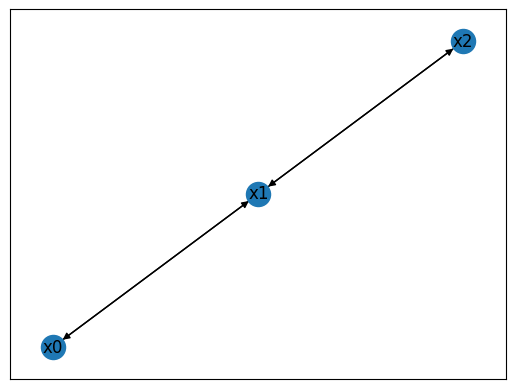

In [3]:
#Wiring diagram of a 3-node network
I = [[1],
     [0,2],
     [1]]

#Create an instance of WiringDiagram
W = boolforge.WiringDiagram(I=I)

#Print basic properties
print(f'W.N: {W.N}')
print(f'W.variables: {W.variables}')
print(f'W.indegrees: {W.indegrees}')
print(f'W.outdegrees: {W.outdegrees}')
print(f'W.N_constants: {W.N_constants}')
print(f'W.N_variables: {W.N_variables}')

#Plot the wiring diagram
DiGraph = W.generate_networkx_graph()
nx.draw_networkx(DiGraph, with_labels=True, arrows=True)

The code above creates and plots the wiring diagram. Since we did not provide the names of the variables (via optional argument `variables`), it used default variable names $x_0,\ldots,x_{N-1}$. Any instance of `WiringDiagram` also contains two vectors of length $N$:
- `indegrees` describes the number of incoming edges (i.e., the number of regulators) per node,
- `outdegrees` describes the number of outgoing edges per node (i.e., the number of nodes this node regulates).

It further contains two integers `N_constants` and `N_variables`, which together always sum up to $N$. The former counts the number of nodes that are constant (nodes with an indegree of 0). The later counts the number of nodes that are not constant, with an indegree $>0$.

The next example contains constants and also nodes, for which their indegree is not the same as their outdegree (note that the average indegree will always equal the average outdegree).

W.N: 3
W.variables: ['x0' 'x1' 'x2']
W.indegrees: [0 2 1]
W.outdegrees: [2 0 1]
W.N_constants: 1
W.N_variables: 2


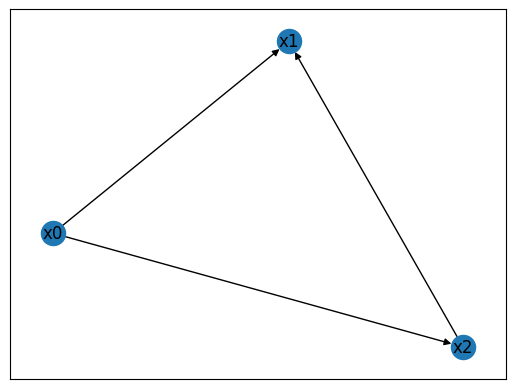

In [4]:
#Wiring diagram of a 3-node network
I = [[],
     [0,2],
     [0]]

#Create an instance of WiringDiagram
W = boolforge.WiringDiagram(I=I)

#Print basic properties
print(f'W.N: {W.N}')
print(f'W.variables: {W.variables}')
print(f'W.indegrees: {W.indegrees}')
print(f'W.outdegrees: {W.outdegrees}')
print(f'W.N_constants: {W.N_constants}')
print(f'W.N_variables: {W.N_variables}')

#Plot the wiring diagram
DiGraph = W.generate_networkx_graph()
nx.draw_networkx(DiGraph, with_labels=True, arrows=True)

This instance of `WiringDiagram` encodes a feed-forward loop, a common recurring patten (*network motif*) found in biological networks. Node $x_0$ is constant and regulates $x_1$ and $x_2$. Node $x_2$ is also regulated by the intermediate node $x_1$.

## Structural decomposition of wiring diagrams

Some wiring diagrams (and Boolean networks built upon these wiring diagrams) can be decomposed into multiple *strongly connected components* (SCCs). SCCs have recently been equated to biological modules (Kadelka et al., Journal of Royal Society Interface, 2023). The class `WiringDiagram` contains methods to perform this decomposition into SCCs and to identify the *directed acyclic graph* (i.e., the *modular structure*) underlying this structural decomposition. Later, when working with Boolean networks, this structural decomposition of the wiring diagram implies a decomposition of the dynamics, facilitating the identification of network dynamics and effective controls.

To exemplify this, we define a wiring diagram with 6 nodes, which can be decomposed into three SCCs.

W.N: 6
W.variables: ['x0' 'x1' 'x2' 'x3' 'x4' 'x5']
W.indegrees: [1 1 1 2 2 1]
W.outdegrees: [1 2 2 1 1 1]
W.N_constants: 0
W.N_variables: 6
SCCs: [{3, 4, 5}, {0, 1}, {2}]
directed acyclic graph of SCCs: {(1, 0), (2, 0)}


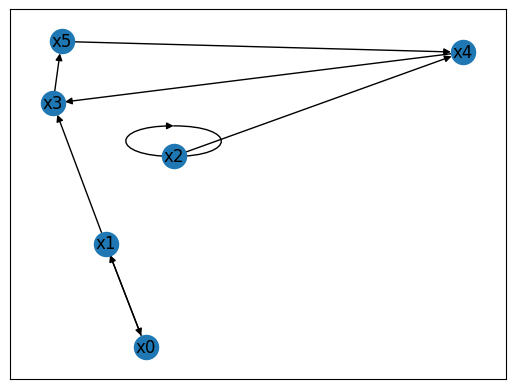

In [5]:
#Wiring diagram of a 6-node network
I = [[1],
     [0],
     [2],
     [1,4],
     [2,5],
     [3]]

#Create an instance of WiringDiagram
W = boolforge.WiringDiagram(I=I)

#Print basic properties
print(f'W.N: {W.N}')
print(f'W.variables: {W.variables}')
print(f'W.indegrees: {W.indegrees}')
print(f'W.outdegrees: {W.outdegrees}')
print(f'W.N_constants: {W.N_constants}')
print(f'W.N_variables: {W.N_variables}')

#Print SCCs and directed acyclic graph structure between SCCs
sccs = W.get_strongly_connected_components()
dag = W.get_modular_structure()
print(f'SCCs: {sccs}')
print(f'directed acyclic graph of SCCs: {dag}')

#Plot the wiring diagram
DiGraph = W.generate_networkx_graph()
nx.draw_networkx(DiGraph, with_labels=True, arrows=True)

The function `get_strongly_connected_components()` uses the `networkx` library to return a unordered list of sets, each set containing the indices of the variables in one SCC. The function `get_modular_structure` provides the partial order between the elements in this list. In the above example, the identified SCCs are $\{x_3, x_4, x_5\}$, $\{x_0, x_1\}$, $\{x_2\}$, and the modular structure is such that SCC $\{x_0, x_1\}$ as well as SCC $\{x_2\}$ are upstream of SCC $\{x_3, x_4, x_5\}$. That means that at least one node in each of the upstream SCCs regulates at least one nodes in the downsteam SCC.

## Create Boolean networks
 
To create a Boolean network of $N$ nodes from scratch, `BoolForge` requires, at a minimum, two inputs:
1. A list of N lists describing the indices of the regulators for each Boolean function. This defines the wiring diagram.
2. A list of N instances of `BooleanFunction` or a list of N binary vectors of length $2^n$ representing the outputs of a Boolean function with n inputs. This defines the specific update functions of each node.

In [7]:
#Wiring diagram of the 3-node network
I = [[1],
     [0,2],
     [1]]

#Boolean functions of a 3-node network
F = [[0,1],
     [0,1,1,1],
     [0,1]]

#Create instance of BooleanNetwork
bn = boolforge.BooleanNetwork(F=F, I=I)

#Print the entire truth table
bn.to_truth_table()

,x0(t),x1(t),x2(t),x0(t+1),x1(t+1),x2(t+1)
0,0,0,0,0,0,0
1,0,0,1,0,1,0
2,0,1,0,1,0,1
3,0,1,1,1,1,1
4,1,0,0,0,1,0
5,1,0,1,0,1,0
6,1,1,0,1,1,1
7,1,1,1,1,1,1


The class `BooleanNetwork` inherits all the functionality and instance variables of `WiringDiagram`. In addition, it contains a few others:
